In [173]:
import mysql.connector
import pandas as pd
import re
import os

In [174]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )
cursor = db_connection.cursor()

In [175]:
df = pd.read_sql("SELECT * FROM reddit", db_connection)

In [176]:
df.drop_duplicates(inplace=True, subset=['title'])

In [177]:
# def clean(text):
#     text = re.sub('[^a-zA-Z]','', text)
#     text = re.sub('\xf1','', text)
#     return text

# df['title'] = clean(df['title'])

In [178]:
# Adding stopwords
from sklearn.feature_extraction import text 
###
import numpy as np
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [179]:
df.head(2)

,id,hour_created,time_created,day_created,author,title,ups,downs,num_comments,text,thumbnail,url,curr_time
0,101,08,08:48:37,2021-02-08,daynestxbbq,[PRO/CHEF] Texas Barbecue Platter,43666,0,1451,,https://b.thumbs.redditmedia.com/8dY2UPIltw6QD...,https://i.redd.it/zclugg5m75g61.jpg,2021-02-08 13:57:10.388548
1,102,03,03:19:56,2021-02-08,jojofaye,[homemade] Whole lemon cake doughnuts with whi...,2508,0,38,,https://b.thumbs.redditmedia.com/voaO-2Yv62C7M...,https://i.redd.it/2dgjjzuxk3g61.jpg,2021-02-08 13:57:10.390814


In [180]:
df['date']= pd.to_datetime(df['day_created'])
df['week'] = df['date'].dt.isocalendar().week

<AxesSubplot:xlabel='week', ylabel='Count'>

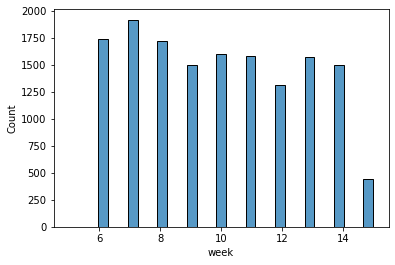

In [181]:
import seaborn as sns
sns.histplot(data=df, x="week")

In [182]:
reindexed_data = df['title']
reindexed_data.index = df['week']

In [183]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

###

# count_vectorizer = CountVectorizer(stop_words='english')
# words, word_values = get_top_n_words(n_top_words=15,
#                                      count_vectorizer=count_vectorizer, 
#                                      text_data=reindexed_data)

# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top words in headlines dataset (excluding stop words)');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()

In [184]:
# Delete Redditors chosen 'categories'
my_additional_stop_words = ['homemade', 'pro', 'chef', 'ate']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

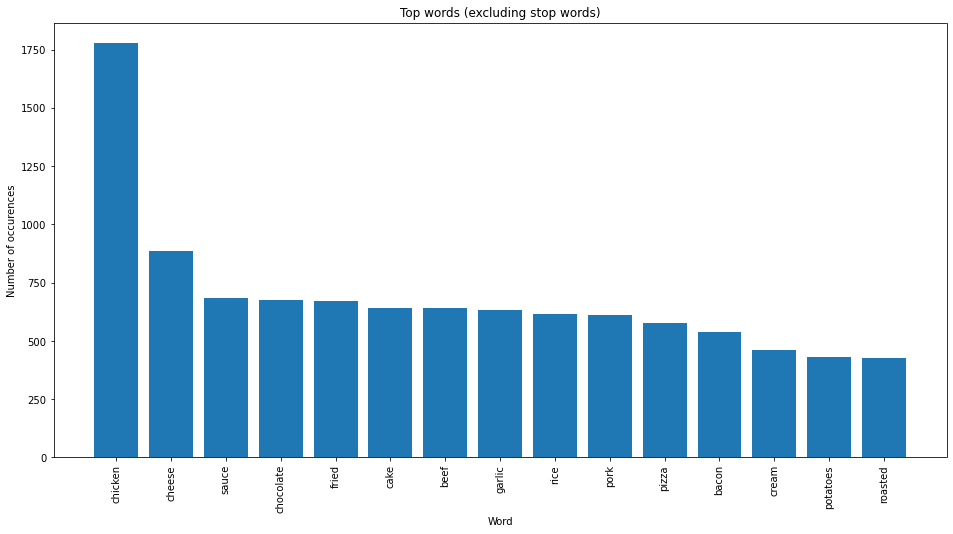

In [185]:
count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Erklärung zum Diagramm

Aufgelistet sind die meist genutzten Wörter. Auffällig ist dabei, wie oft das Wort Chicken im Vergleich zu den anderen Fleischsorten vorkommt. Vielleicht lässt sich dieser Zusammenhang auch mithilfe der demographischen Faktoren der Zielgruppe erklären, welche Reddit nutzen. Vor allem vor dem Hintergrund des Alters und des häufig damit einhergehenden Einkommens, ist es wahrscheinlich, dass Chicken besonders beliebt ist, da es das verfügbarste Fleisch ist.

Eine andere Besonderheit ist, dass hauptsächlich Zutaten gelistet sind. Jedoch gibt es die Einträge Kuchen und Pizza, was uns vermuten lässt, dass die beiden Gerichte am häufigsten in r/food vorkommen.

# LDA

In [186]:
# Unoptimized number of topics for proof of concept
n_topics = 5

In [187]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [188]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(" ".join(topic_words))         
    return top_words

In [189]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [190]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [191]:
sample_size = len(df) 

count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
text_sample = reindexed_data.sample(n=sample_size, random_state=0).values
document_term_matrix = count_vectorizer.fit_transform(text_sample)

lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online')
lda_model.fit(document_term_matrix);

In [192]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0,
                                     topic_word_prior=0.5, doc_topic_prior=0.01)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [193]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [194]:
top_n_words_lda = get_top_n_words(7, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i), top_n_words_lda[i])

Topic 0:  chicken beef pork fried rice smoked curry
Topic 1:  chicken garlic sauce cheese steak potatoes roasted
Topic 2:  chocolate cake cream cheese cookies burger eggs
Topic 3:  pizza chicken sandwich cheese pie pasta pepperoni
Topic 4:  chicken bread breakfast french ramen sourdough toast


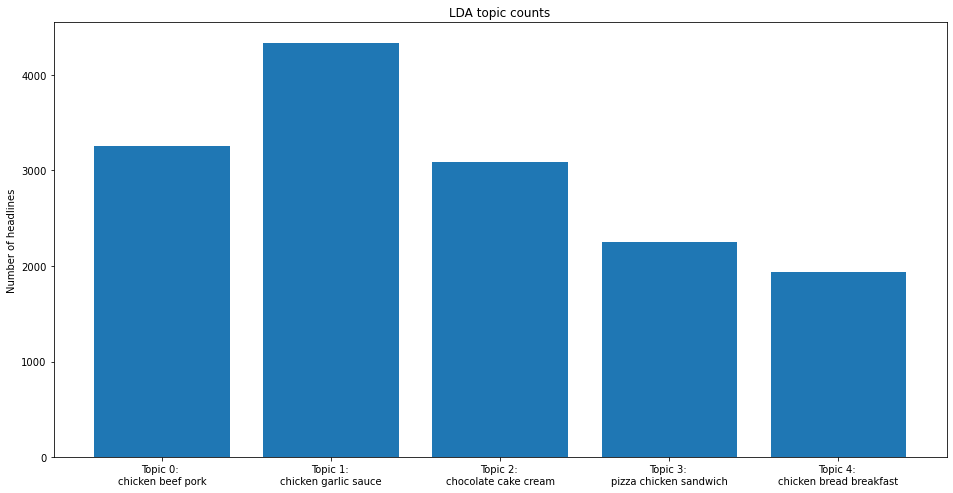

In [195]:
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [196]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14863 samples in 0.047s...
[t-SNE] Computed neighbors for 14863 samples in 0.556s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14863
[t-SNE] Computed conditional probabilities for sample 2000 / 14863
[t-SNE] Computed conditional probabilities for sample 3000 / 14863
[t-SNE] Computed conditional probabilities for sample 4000 / 14863
[t-SNE] Computed conditional probabilities for sample 5000 / 14863
[t-SNE] Computed conditional probabilities for sample 6000 / 14863
[t-SNE] Computed conditional probabilities for sample 7000 / 14863
[t-SNE] Computed conditional probabilities for sample 8000 / 14863
[t-SNE] Computed conditional probabilities for sample 9000 / 14863
[t-SNE] Computed conditional probabilities for sample 10000 / 14863
[t-SNE] Computed conditional probabilities for sample 11000 / 14863
[t-SNE] Computed conditional probabilities for sample 12000 / 14863
[t-SNE] Computed conditional probabilities for sa

In [197]:
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

Hier erkennt man, dass die Themen sich nicht stark voneinander abgrenzen.

In [198]:
# Trends

In [199]:
weekly_data = []
# min.week+1 weil in der untersten Woche nur ein post erfasst ist (?)
for i in range(df.week.min()+1,df.week.max()+1):
    weekly_data.append(reindexed_data[i].values)

weekly_topic_matrices = []
for week in weekly_data:
    document_term_matrix = count_vectorizer.transform(week)
    topic_matrix = lda_model.transform(document_term_matrix)
    weekly_topic_matrices.append(topic_matrix)

weekly_keys = []
for topic_matrix in weekly_topic_matrices:
    weekly_keys.append(get_keys(topic_matrix))
    
weekly_counts = []
for keys in weekly_keys:
    categories, counts = keys_to_counts(keys)
    weekly_counts.append(counts)

weekly_topic_counts = pd.DataFrame(np.array(weekly_counts), index=range(df.week.min()+1,df.week.max()+1))
weekly_topic_counts.columns = ['Topic {}'.format(i) for i in range(n_topics)]

print(weekly_topic_counts)

    Topic 0  Topic 1  Topic 2  Topic 3  Topic 4
6       221      405      488      361      258
7       401      278      557      387      293
8       329      512      264      222      391
9       470      203      309      212      301
10      315      222      471      387      200
11      397      427      207      323      224
12      382      153      307      261      212
13      425      350      256      334      206
14      237      309      467      293      190
15       97       91       70       55      132


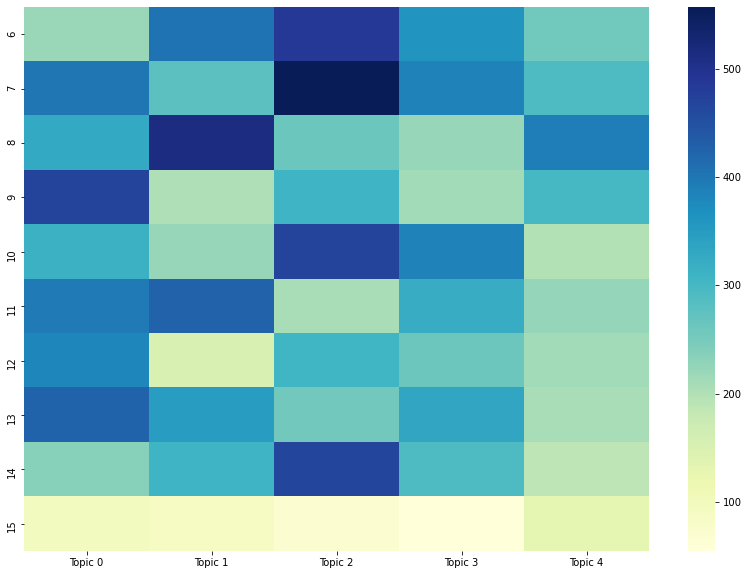

In [200]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(weekly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()

Es ist kein Trend innerhalb des Erfassungszeitraums erkennbar.